In [1]:
import sys
import os
import torch
import numpy as np
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)
from ssast_model import ASTModel
import soundfile as sf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchaudio
import pickle
import librosa

In [2]:
# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Print information about the audio
print("Time of last sample:", time[-1])
print("Number of samples:", len(audio_signal))
print("Sample rate:", sample_rate)
print("Duration of audio:", len(audio_signal) / sample_rate)
print("Shape of audio signal:", audio_signal.shape)
print("Type of audio signal:", type(audio_signal))
print("Data type of audio signal:", audio_signal.dtype)


# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)
print("Type of audio tensor:", type(audio_tensor))
print("Data type of audio tensor:", audio_tensor.dtype)
print("Shape of audio tensor:", audio_tensor.shape)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()
print("Data type of audio tensor:", audio_tensor.dtype)

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)
print("Shape of audio tensor:", audio_tensor.shape)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
print(f"Shape of fbank features: {fbank_features.shape}")

Time of last sample: 9.9999375
Number of samples: 160000
Sample rate: 16000
Duration of audio: 10.0
Shape of audio signal: (160000,)
Type of audio signal: <class 'numpy.ndarray'>
Data type of audio signal: float64
Type of audio tensor: <class 'torch.Tensor'>
Data type of audio tensor: torch.float64
Shape of audio tensor: torch.Size([160000])
Data type of audio tensor: torch.float32
Shape of audio tensor: torch.Size([1, 160000])
Shape of fbank features: torch.Size([998, 128])


In [3]:
# Assuming audio_signal and sample_rate are defined previously
mel_librosa = librosa.feature.melspectrogram(
    y=audio_signal,  # specify the audio data with keyword argument
    sr=sample_rate,
    n_mels=128,
    hop_length=160,  # 10 ms = 160 * 1/16000
    n_fft=400,       # 25 ms = 400 * 1/16000
    center=False,
    fmin=0.0,
    fmax=None        # default Nyquist frequency
)

# Print shape, minimum, and maximum value of the mel spectrogram
print(f"Shape of mel spectrogram computed by librosa: {mel_librosa.shape}")
print(f"Minimum value of mel spectrogram computed by librosa: {mel_librosa.min()}")
print(f"Maximum value of mel spectrogram computed by librosa: {mel_librosa.max()}")

# Parameters for inversion to closely match feature extraction settings
sr = sample_rate
n_fft = 400
hop_length = int(0.01 * sr)  # 10 ms
win_length = int(0.025 * sr)  # 25 ms
window = 'hanning'

# Reconstruct the audio without explicitly specifying the length
y = librosa.feature.inverse.mel_to_audio(mel_librosa, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
                                         window=window, n_iter=32)

# Check the length of the reconstructed audio
print("\nLength of reconstructed audio (samples) using librosa:", len(y))
print("Duration of reconstructed audio (seconds) using librosa:", len(y) / sr)




# Convert tensor fbank_features back to numpy array and transpose it
M = fbank_features.cpu().numpy().T
print("\n\nshape of mel spectrogram computed by torchaudio:", M.shape)
print("min of mel spectrogram computed by torchaudio:", M.min())
print("max of mel spectrogram computed by torchaudio:", M.max())


# Convert tensor fbank_features back to numpy array, transpose, and convert from dB to power
M = fbank_features.cpu().numpy().T
M_linear = np.exp(M)

print("shape of mel spectrogram computed by torchaudio (adjusted to power):", M_linear.shape)
print("min of mel spectrogram computed by torchaudio (adjusted to power):", M_linear.min())
print("max of mel spectrogram computed by torchaudio (adjusted to power):", M_linear.max())

M = M_linear


# Parameters for inversion to closely match feature extraction settings
sr = sample_rate
n_fft = 400
hop_length = int(0.01 * sr)  # 10 ms
win_length = int(0.025 * sr)  # 25 ms
window = 'hanning'

# Reconstruct the audio without explicitly specifying the length
y = librosa.feature.inverse.mel_to_audio(M, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
                                         window=window, n_iter=50)

# Check the length of the reconstructed audio
print("\nLength of reconstructed audio (samples):", len(y))
print("Duration of reconstructed audio (seconds):", len(y) / sr)

Shape of mel spectrogram computed by librosa: (128, 998)
Minimum value of mel spectrogram computed by librosa: 7.549237594184445e-11
Maximum value of mel spectrogram computed by librosa: 11.846005517992044

Length of reconstructed audio (samples) using librosa: 159520
Duration of reconstructed audio (seconds) using librosa: 9.97


shape of mel spectrogram computed by torchaudio: (128, 998)
min of mel spectrogram computed by torchaudio: -15.942385
max of mel spectrogram computed by torchaudio: 4.2850385
shape of mel spectrogram computed by torchaudio (adjusted to power): (128, 998)
min of mel spectrogram computed by torchaudio (adjusted to power): 1.1920935e-07
max of mel spectrogram computed by torchaudio (adjusted to power): 72.60534

Length of reconstructed audio (samples): 159520
Duration of reconstructed audio (seconds): 9.97


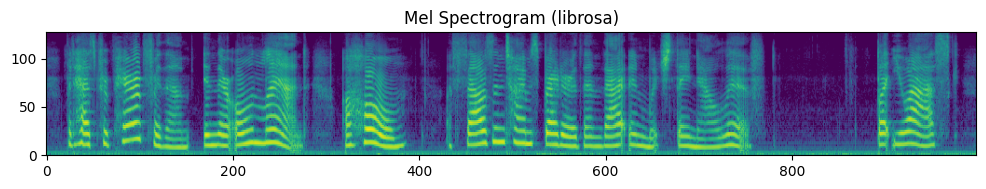

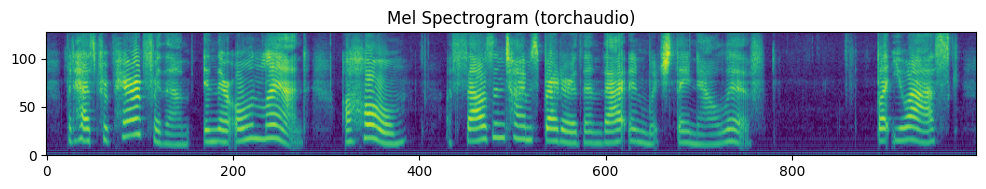

In [4]:
# plot the mel spectrogram computed by librosa on dB scale
plt.figure(figsize=(12, 1.6))
plt.title('Mel Spectrogram (librosa)')
plt.imshow(librosa.power_to_db(mel_librosa), aspect='auto', origin='lower', cmap='viridis')

# plot the mel spectrogram computed by torchaudio on dB scale
plt.figure(figsize=(12, 1.6))
plt.title('Mel Spectrogram (torchaudio)')
plt.imshow(librosa.power_to_db(M), aspect='auto', origin='lower', cmap='viridis')

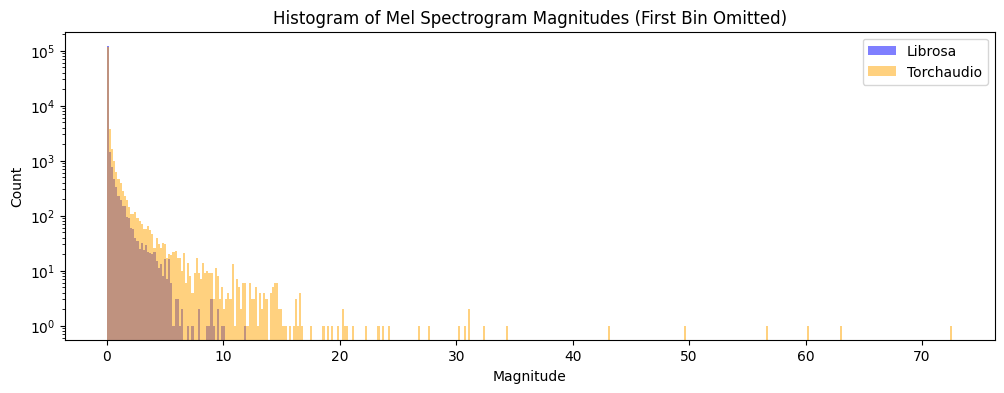

In [5]:
# Flatten the spectrogram arrays to 1D
mel_librosa_flat = mel_librosa.flatten()
M_flat = M.flatten()

# Calculate histogram bin edges
bins = np.histogram(np.hstack((mel_librosa_flat, M_flat)), bins=400)[1]  # Get only the bin edges

# Exclude the first bin by starting from the second bin's minimum edge
custom_bins = bins[0:]  # Start from the second bin

plt.figure(figsize=(12, 4))
plt.hist(mel_librosa_flat, bins=custom_bins, alpha=0.5, label='Librosa', color='blue', log=True)
plt.hist(M_flat, bins=custom_bins, alpha=0.5, label='Torchaudio', color='orange', log=True)
plt.legend()
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.title('Histogram of Mel Spectrogram Magnitudes (First Bin Omitted)')
plt.show()